In [39]:
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from src.auxil import plot_estimates, plot_rmse, plot_traj, rmse
from src.kalmanfilter import KalmanFilter
from src.kfnet import KFNet
from src.statespace import CAModel, CVModel, RWModel, StateSpace
from src.trajectory import Trajectory

# sns.set()
sns.set_style("white")
# plt.style.use('seaborn-poster')

In [40]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
RANDOM_SEED = None
ndat = 100
q = 9.5e-5  # Process noise intensity
r = 1.3  # Observation noise std
c_rwm = 10  # RWM process noise scaling constant
expf = 0.95  # Exponential forgetting param
reset_thresh = 10.0  # Filter reset threshold (Euclidean distance from centroid)
init_state = np.zeros(6)

In [42]:
KFN_SEED = 5

kfsr = [
    KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
    KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfsr)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

kfnr = KFNet(10, 7, init=kfsr, random_seed=KFN_SEED)
np.random.seed()
kfnr.generate_txt_labels()
# kfn.draw_network()

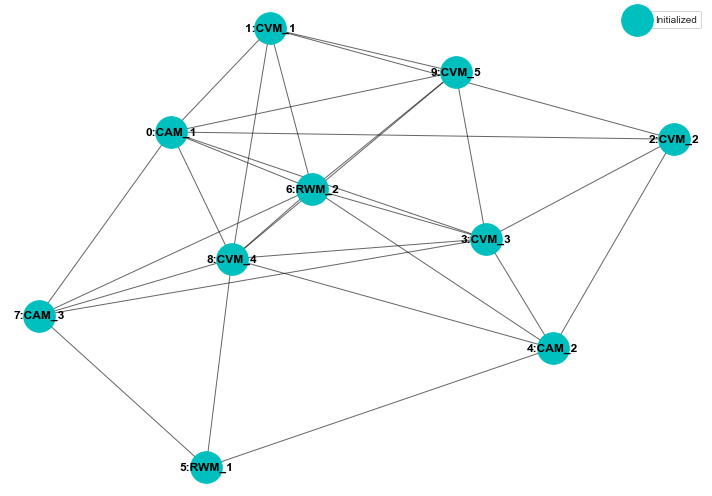

In [43]:
KFN_SEED = 5

kfs = [
    KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
    KalmanFilter(RWModel(c_rwm * q, r), lambda_expf=expf),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CVModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
    KalmanFilter(CAModel(q, r)),
]
np.random.seed(KFN_SEED)
np.random.shuffle(kfs)
# lbls = ["RWM", "CVM", "CAM"]
# lbls = {n:lbl for n, lbl  in enumerate(lbls)}

kfn = KFNet(10, 7, init=kfs, random_seed=KFN_SEED)
np.random.seed()
kfn.generate_txt_labels()
kfn.draw_network()

In [44]:
# Trajectory simulator initialization
R = kfn.observation_covs()

traj = Trajectory(
    CAModel(q, r), n_steps=ndat, init_state=init_state, R=R, random_seed=None
)

In [45]:
for yt in traj.observations:
    #     kfn.time_step(
    #         yt,
    #         predict=True,
    #         update=True,
    #         adapt=True,
    #         combine=True,
    #         reset_strategy="mean",
    #         reset_thresh=reset_thresh,
    #         c=3.0
    #     )

    kfn.predict()
    #     kfn.reset_filters(reset_strategy="mean", reset_thresh=reset_thresh, c=1.0)
    kfn.update(yt)
    kfn.adapt()
    kfn.combine()
    kfn.log()

    kfnr.reset_filters(reset_strategy="ci", reset_thresh=reset_thresh, c=1.0)
    kfnr.predict()
    kfnr.update(yt)
    kfnr.adapt()
    kfnr.combine()
    kfnr.log()

In [46]:
RWM = kfn[6]
CVM = kfn[3]
CAM = kfn[7]

In [47]:
kfcam = KalmanFilter(CAModel(q, r))

for yt in traj.observations[:, 0]:
    kfcam.predict()
    kfcam.update(yt, log=True)

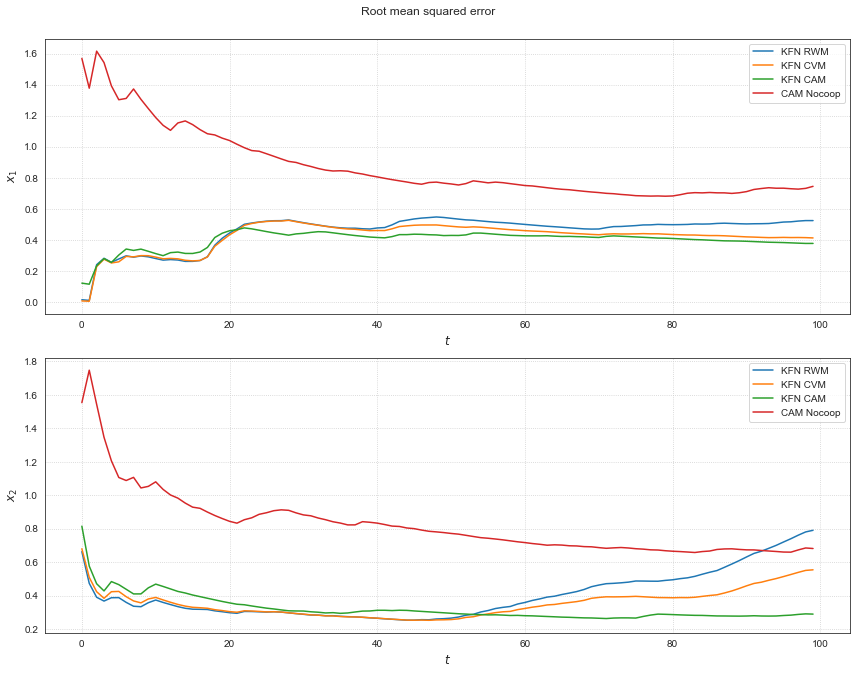

In [48]:
plot_rmse(
    traj,
    RWM,
    CVM,
    CAM,
    kfcam,
    nvars=2,
    var_labels=["$x_1$", "$x_2$"],
    kf_labels=["KFN RWM", "KFN CVM", "KFN CAM", "CAM Nocoop"],
)

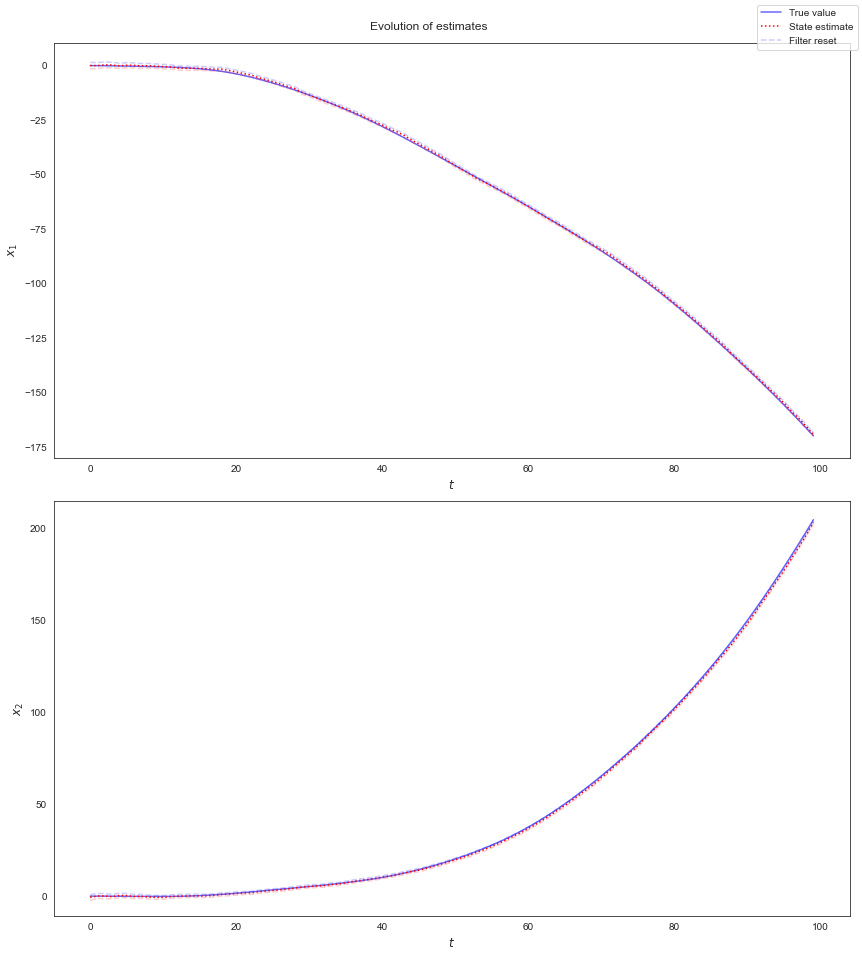

In [49]:
plot_estimates(RWM, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])

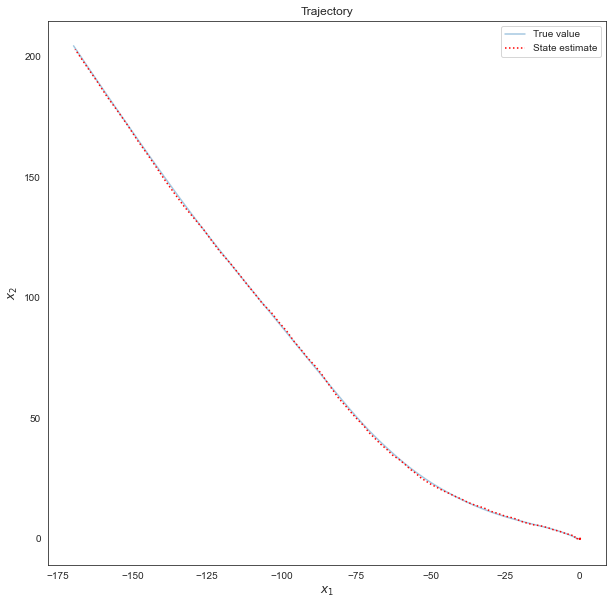

In [50]:
plot_traj(traj, kf=RWM)

In [51]:
import pickle

filename = "traj.pkl"
with open(filename, "wb") as f:
    pickle.dump(obj=traj, file=f)

In [52]:
filename = "rwm.pkl"
with open(filename, "wb") as f:
    pickle.dump(obj=RWM, file=f)

In [53]:
RWM_kfn = kfn[6]
RWM_kfnr = kfnr[6]

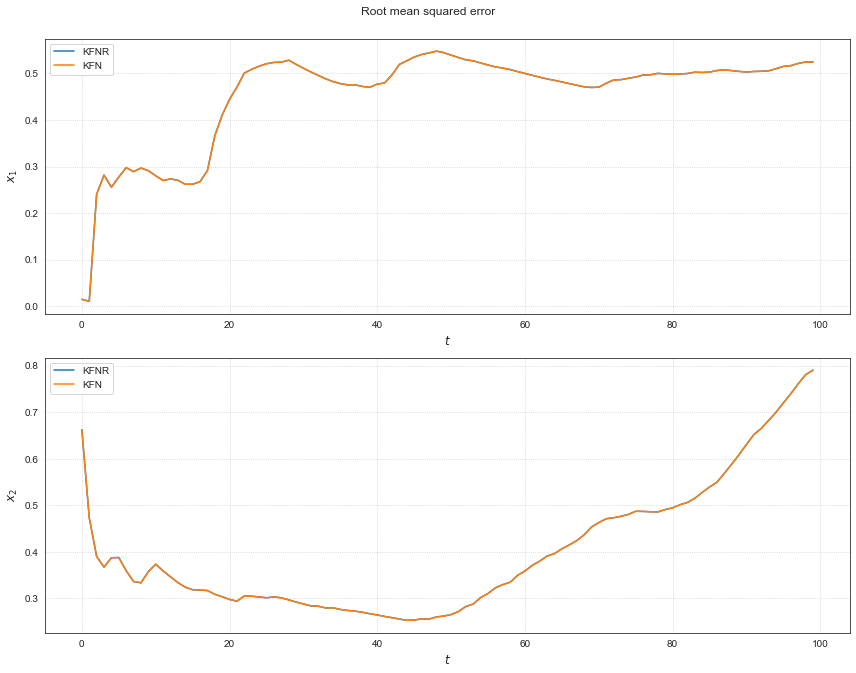

In [54]:
plot_rmse(
    traj,
    RWM_kfnr,
    RWM_kfn,
    nvars=2,
    var_labels=["$x_1$", "$x_2$"],
    kf_labels=["KFNR", "KFN"],
)

In [55]:
print(len(RWM_kfnr._reset_log))
print(len(RWM_kfn._reset_log))

0
0


In [56]:
np.allclose(RWM_kfnr.history, RWM_kfn.history, rtol=1e-4, atol=1e-4)

True

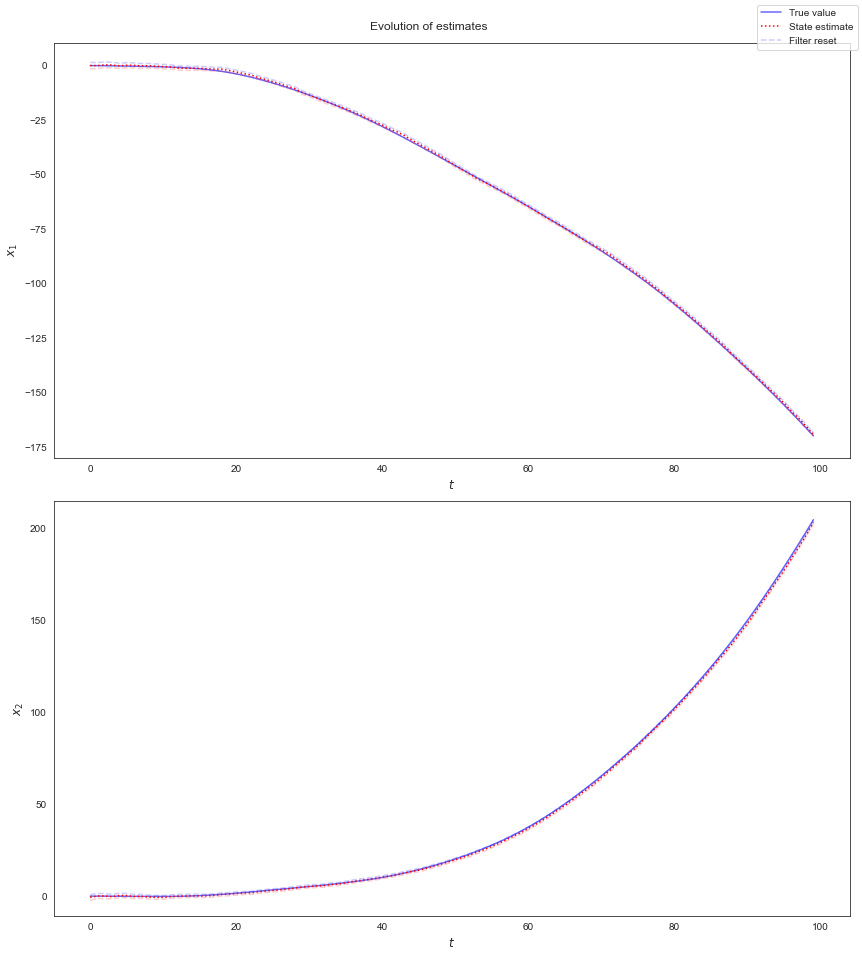

In [57]:
plot_estimates(RWM_kfnr, traj, nvars=2, plt_std=True, labels=["$x_1$", "$x_2$"])